### Import packages and additional setup to read the test image and for displaying plots

In [43]:
import sep
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import fits

%matplotlib inline

rcParams['figure.figsize'] = [10.0, 8.0]

### Open the image and store as a 2D array

In [44]:
fname = "image.fits"
hdu_list = fits.open(fname)
image_data = fits.getdata(fname)

ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


### Check dimensions

In [45]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(256, 256)


### Show the image

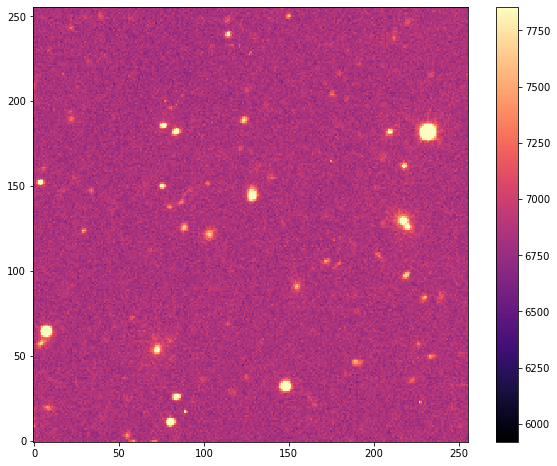

In [72]:
image_data_mean = np.mean(image_data)
image_data_std = np.std(image_data)
plt.imshow(image_data, 
                   cmap = 'magma', 
                   interpolation = 'nearest', 
                   vmin = image_data_mean - image_data_std, 
                   vmax = image_data_mean + image_data_std, 
                   origin = 'lower')
plt.colorbar()
plt.savefig('image.png')

## Background subtraction

### Return a background object that holds information on spatially varying background and noise level

In [47]:
#measure a spatially varying background on the image
bkg = sep.Background(image_data)

### Get a "global" mean and noise of the image background

In [48]:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


### Evaluate background as 2D array (image is same size as original)

In [49]:
bkg_image = np.array(bkg)

### Show background

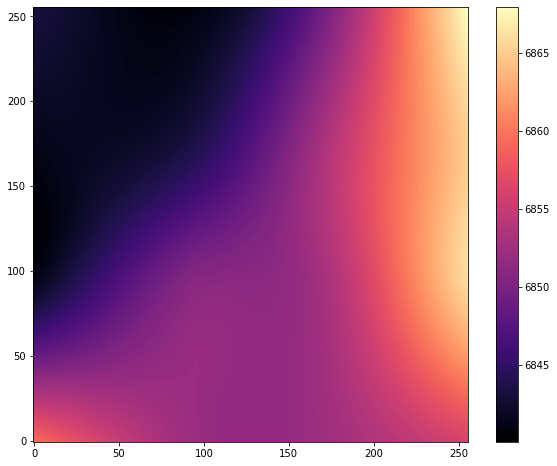

In [73]:
plt.imshow(bkg_image, 
           interpolation = 'nearest', 
           cmap = 'magma', 
           origin = 'lower')
plt.colorbar()
plt.savefig('image_bkg.png')

### Evaluate background noise as 2D array

In [51]:
bkg_rms = bkg.rms()

### Show background noise

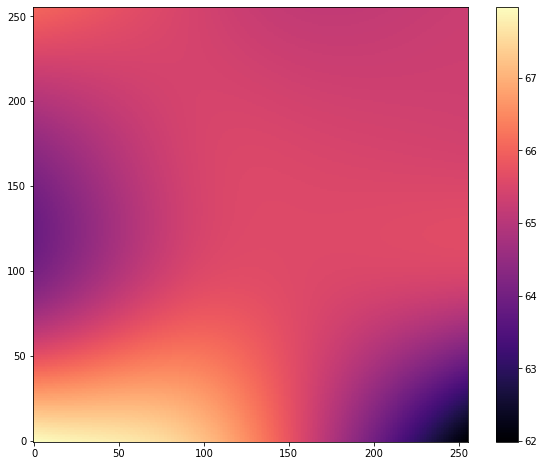

In [74]:
plt.imshow(bkg_rms, 
           interpolation = 'nearest', 
           cmap = 'magma', 
           origin = 'lower')
plt.colorbar()
plt.savefig('image_noise.png')

### Subtract the background

In [53]:
data_sub = image_data - bkg

## Object detection

### Using background-subtracted data to run object detection...

### Background noise is flat, so set detection threshold as 1.5s where s is the global background RMS

In [54]:
s = bkg.globalrms
objects = sep.extract(data_sub, 1.5, err = s)

### Check to see how many objects were detected

In [55]:
len(objects)

68

### To check where the detected objects are, over-plot basic coordinates with some shape parameters

In [56]:
#import to plot an ellipse
from matplotlib.patches import Ellipse

### Plot background-subtracted image with subplots

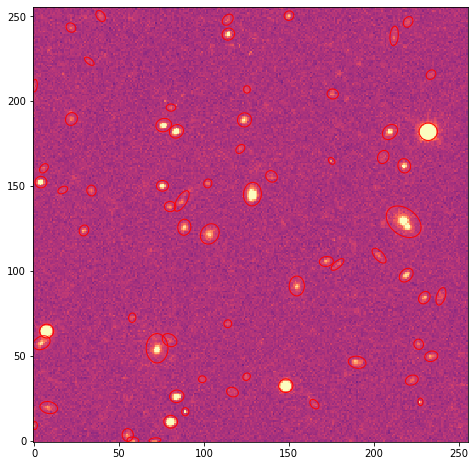

In [75]:
fig, ax = plt.subplots()
data_sub_mean = np.mean(data_sub)
data_sub_std = np.std(data_sub)
bkg_sub_image = ax.imshow(data_sub, 
                          interpolation = 'nearest',
                          cmap = 'magma',
                          vmin = data_sub_mean - data_sub_std,
                          vmax = data_sub_mean + data_sub_std,
                          origin = 'lower')

# plot an ellipse for each object
for i in range(len(objects)):
    
    # objects['x'] and objects['y'] gives centroid coordinates of the objects
    # ellipse parameters for each object
    
    x = objects['x'][i]
    y = objects['y'][i]
    width = 6*objects['a'][i]
    height = 6*objects['b'][i]
    angle = objects['theta'][i] * 180.0/np.pi
    e = Ellipse(xy = (x , y),
                width = width,
                height = height,
                angle = angle)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
plt.savefig('image_final.png')

### [objects] has other fields which give information like second moments and peak pixel positions and values. To see available fields:

In [61]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture photometry

### To perform simple circular photometry with a 3 pixel radius at object locations

In [63]:
flux, fluxerr, flag = sep.sum_circle(data_sub, 
                                     objects['x'], 
                                     objects['y'],
                                     3.0, 
                                     err = s, 
                                     gain = 1.0)

#flux, fluxerr, and flag are 1D arrays with one entry per object

### To show first 10 objects results

In [64]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))


object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138
